In [27]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import hybrid_functions as motor
import os
import logging

###############################################################################
# Input parameters
###############################################################################

VOL_TANK = 12 * 0.001          # tank volume (m^3)

TEMPERATURE = 10 + 273.15       # initial tank temperature (K) if pressure measured instead, leave at 0

PRESSURE = 0                    # initial tank pressure (Pa) if temperature measured instead, leave at 0

if(PRESSURE):
    TEMP = motor.pressure_to_temp(PRESSURE)
"""Do not use both pressure and temperature, their are dependent values"""

M_HE = 0.000                        #pressurant mass, leave at 0 if not externally pressurized

R_HE = 8314/4                   #change if using another gas to pressurize (J/kgK)

HEAD_SPACE = 0.15               #volume fraction of gas after tanking

OXIDIZER_MASS = 0           #change from 0 only if oxidizer mass is known, head space will be then ignored 
                                #and calculated from mass and temperature
                                #temperature calculation from mass and headspace is not reccomended (and currently unsupported)
if OXIDIZER_MASS:
    HEAD_SPACE = motor.mass_to_headspace(TEMPERATURE, VOL_TANK, OXIDIZER_MASS)
    if HEAD_SPACE < 0:
        raise RuntimeError('Impossible mass!')
NUM_INJ = 8                 # number of primary injector orifices

DIA_INJ = 2.5*0.001             # diameter of primary injector orifices (m)

DIA_PORT = 40*0.001           # diameter of fuel port (m)

LENGTH_PORT = 0.8              # length of fuel port (m)

DIA_FUEL = 100*0.001             # Outside diameter of fuel grain (m)

C_STAR_EFFICIENCY = 0.94        # Ratio between actual and theoretical

DIA_THROAT = 26*0.001           # nozzle throat diameter (m)

NOZZLE_EFFICIENCY = 0.97        # factor by which to reduce thrust coefficient

NOZZLE_AREA_RATIO = 4           # ratio of nozzle exit area to throat area

DIA_FEED = 0.010                # feed pipe diameter (m)

LENGTH_FEED = 0.2                 # feed pipe length (m)

VALVE_MODEL_TYPE = 'ball'       # either 'kv' or 'ball' (models as thick orifice)

KV_VALVE = 5                    # used if VALVE_MODEL_TRY='kv'

DIA_VALVE = 0.01                # used if VALVE_MODEL_TRY='ball'

LENGTH_VALVE = 0.05             # used if VALVE_MODEL_TRY='ball'

DENSITY_FUEL = 955             # solid fuel density (kg m^-3)

REG_COEFF = 2.52E-5             # regression rate coefficient (usually 'a' in literature)

REG_EXP = 0.76                   # regression rate exponent (usually 'n' in literature)

PRES_EXTERNAL = 87000           # external atmospheric pressure at test site (Pa)

MINIMAL_THRUST = 10             #thrust below which engine burnout is considered

dt = 10e-3                      # time step (s)
###############################################################################
#End of required user input
###############################################################################
from datetime import datetime
logname=datetime.now().strftime("log/%d.%m.%y-%H.%M")+" - log.txt"
logging.basicConfig(filename=logname, level=logging.DEBUG, format="%(message)s")

# Create pipes for pipe-like things, bit messy
portA   = motor.area(DIA_PORT)
fuelA   = motor.area(DIA_FUEL)
throatA = motor.area(DIA_THROAT)
feedA   = motor.area(DIA_FEED)
valveA  = motor.area(DIA_VALVE)
portL=LENGTH_PORT
feedL=LENGTH_FEED
valveL=LENGTH_VALVE
portD=DIA_PORT
feedD=DIA_FEED
valveD=DIA_VALVE
fuelD=DIA_FUEL


###############################################################################
# Initialize simulation
###############################################################################

if 'dracula' in plt.style.available:
    plt.style.use('dracula')
else:
    plt.style.use('seaborn-whitegrid')



#open propep data file
propep_file = open('data/L_Nitrous_S_HDPE.propep', 'r')
propep_data = propep_file.readlines()

# assign initial values
time = 0
time_steps = 0
mdotox = 0
impulse = 0
blowdown_type = 'liquid'
entry_loss = 0
vmdotspi = 0
vmdothem = 0
headspace = HEAD_SPACE
temp = TEMPERATURE
pres_cham = 2e6 #change if unstable

# temperature/pressure dependent properties of nitrous oxide inside the tank
lden, vden, lh, vap_pres, ldynvis, ls = motor.thermophys(TEMPERATURE)

#calculate initial propellant masses and internal energy
lmass = VOL_TANK * (1 - HEAD_SPACE) * lden
vmass = VOL_TANK * HEAD_SPACE * vden
U=motor.initial_U(temp, lmass, vmass)
fuel_mass = (fuelA - portA) * portL * DENSITY_FUEL
tmass = lmass + vmass
print('N2O mass in tank: '+str(round(tmass,3))+' kg') #useful to check data correctness
print('Vapour volume is '+str(round(headspace*100,1))+'% of the tank volume')
(  # create empty lists to fill with output data
    time_data,
    manifold_pres_data,
    vap_pres_data,
    pres_cham_data,
    U_data,
    temp_data,
    headspace_data,
    mdotox_data,
    gox_data,
    prop_mass_data,
    vmass_data,
    lmass_data,
    fuel_mass_data,
    gamma_data,
    mach_exit_data,
    thrust_data,
    portD_data,
    rdot_data,
    pres_exit_data,
    of_data
) = [[] for _ in range(20)]


print('Initialization done')

N2O mass in tank: 8.899 kg
Vapour volume is 15.0% of the tank volume
Initialization done


In [28]:
###############################################################################
# Simulation loop
###############################################################################

while True:
    time += dt  # increment time
    time_steps += 1 #independent from time step
    if time_steps%100==0:
        print('Time: '+str(round(time,1))) #to check if it's running
    # calculate feed system losses (only attemped for liquid phase)
    he_pres = M_HE* R_HE * temp / (VOL_TANK * headspace) #additional pressure from hellium
    if (lmass<0.01 and blowdown_type == 'liquid'):  # check for liquid depletion
                blowdown_type = 'vapour'
                lmass = 0
                vmass = tmass
                
    if mdotox > 0 and lmass > 0:
        flow_speed = mdotox / (lden * feedA)
        entry_loss = 0.5 * lden * (flow_speed ** 2)  # loss at tank entry

        reynolds = lden * flow_speed * feedD / ldynvis
        f = motor.Nikuradse(reynolds)

        # loss in pipe
        vis_pdrop = 0.25 * f * lden * (flow_speed**2) * feedL / feedD
        logging.debug('Pressure drop from viscosity in feed, MPa: '+str(vis_pdrop/1e6))

        if VALVE_MODEL_TYPE == 'ball':
            #valve loss from full bore ball valve modelled as thick orifice
            valve_loss = (0.5 * lden * flow_speed * flow_speed
                          * motor.ball_valve_K(reynolds, feedD, valveD,
                                               valveL))

        elif VALVE_MODEL_TYPE == 'kv':
            valve_loss = (1.296e9 * mdotox * mdotox /
                          (lden * KV_VALVE * KV_VALVE))

        # sum pressure drops
        manifold_pres = vap_pres - entry_loss - vis_pdrop + he_pres# - valve_loss
    else:
        manifold_pres = vap_pres + he_pres

    inj_pdrop = manifold_pres - pres_cham
    
    logging.debug('\n---------------'+str(round(time,4))+'---------------')
    logging.debug('Temperature, K: '+str(temp))
    logging.debug('Manifold pressure, MPa: '+str(manifold_pres/1e6))
    logging.debug('Entry loss, MPa: '+str(entry_loss/1e6))
    logging.debug('Vapour pressure, MPa: '+str(vap_pres/1e6))

    if inj_pdrop < 0.15 and time_steps > 10:
        print(f'FAILURE: Reverse flow occurred at t={time} s')
        break

    """Pressure is highly unstable during simulation, so additional iteration is used to find stable configuration
    of oxidizer flow and chamber pressure given only tank conditions (temperature and mass composition)"""
    
    pressure_iteration=0
    while True:
        #calculate injector pressure drop
        inj_pdrop = manifold_pres - pres_cham
        # model tank emptying
        if blowdown_type == 'liquid':
            # liquid phase blowdown

            mdotox = motor.dyer_injector(
                pres_cham, DIA_INJ, lden, inj_pdrop,
                lh, manifold_pres, vap_pres, ls, NUM_INJ
            )

            # find new mass and internal energy of tank contents after outflow
            tmass_new = tmass - mdotox * dt
            U_new = U - lh*mdotox*dt
            #calculate N2O properties based on density and total energy
            temp, lden, lh, vap_pres, ldynvis, ls, lmass_new, vmass_new = motor.thermophys_liquid(U_new, tmass_new, VOL_TANK)
                
        else:
            # vapour phase blowdown

            # calculations for injector orifices
            vden = vmass/VOL_TANK
            vap_pres, temp, vs, vh, vu = motor.thermophys_vapour(vden)
            U_new = vu*vmass
            mdotox = motor.dyer_injector_vapour(vden, DIA_INJ, NUM_INJ, manifold_pres, pres_cham, vs, vh)
            vmass_new = vmass - dt * mdotox 

        # fuel port calculation
        rdot = REG_COEFF * pow(mdotox/portA, REG_EXP)
        mdotfuel = rdot * DENSITY_FUEL * np.pi * portD * portL
        of_ratio = mdotox / mdotfuel
        portD_new = portD + 2*rdot*dt
        portA_new=motor.area(portD_new)
        if portD_new > fuelD: #check for depleted fuel grain
            raise RuntimeError('Fuel depleted!')
            #print("Fuel depleted")
            break

        fuel_mass_new = (fuelA - portA_new) * portL * DENSITY_FUEL

        # lookup characteristic velocity using previous
        # pres_cham and current OF from propep data
        c_star = (motor.c_star_lookup(pres_cham, of_ratio, propep_data)
                  * C_STAR_EFFICIENCY)
        
        # calculate current chamber pressure
        pres_cham_iter =(mdotox + mdotfuel) * c_star / throatA
        delta_pres_cham=abs(pres_cham_iter-pres_cham)
        
        logging.debug('\n---Pressure iteriation for time '+str(round(time,2))+'---')
        logging.debug('Currently '+str(pressure_iteration)+' iterations were done')
        logging.debug('Current chamber pressure, MPa: '+str(pres_cham/1e6))
        logging.debug('Oxidizer mass flow, kg/s: '+str(mdotox))
        logging.debug('Regression, mm/s: '+str(rdot*1000))
        logging.debug('Fuel mass flow, kg/s: '+str(mdotfuel))
        logging.debug('Current O/F ratio: ' + str(of_ratio))
        logging.debug('New chamber pressure, MPa: '+str(pres_cham_iter/1e6))
        
        if delta_pres_cham<0.03e6:
            """ If pressure drop beetween time steps was low, results for current time step are considered
            to be accurate. If pressure drop was to high, old pressure is modified a bit to recalculate 
            properties and to find stable configuration. It allows usage of large timestep """
            if pressure_iteration>10:
                logging.warning('##############Pressure converged with more than 10 iteration: '+str(pressure_iteration)+'. Occured at t='+str(round(time,3))+'##########')
            pres_cham = pres_cham_iter
            break
        alpha=0.07
        pres_cham=(1-alpha)*pres_cham+alpha*pres_cham_iter
        pressure_iteration+=1
        if pressure_iteration>500:
            raise RuntimeError('No pressure convergance! '+str(time))
            break
        logging.debug('Iteration done with final pressure: '+str(pres_cham/1e6))
    
    #keep final variables from changes during pressure iteration
    tmass=tmass_new
    lmass=lmass_new
    vmass=vmass_new
    headspace = (VOL_TANK-lmass/lden)/VOL_TANK
    portD=portD_new
    portA=portA_new
    fuel_mass=fuel_mass_new
    U=U_new

    # lookup ratio of specific heats from propep data file
    gamma = motor.gamma_lookup(pres_cham, of_ratio, propep_data)

    # performance calculations
    mach_exit, pres_exit, thrust = motor.nozzle(gamma, NOZZLE_AREA_RATIO, throatA,
                                                 pres_cham, NOZZLE_EFFICIENCY, PRES_EXTERNAL)

    if thrust<MINIMAL_THRUST and time_steps>10:
        print('Engine burnout')
        break
    #update data lists
    time_data.append(time)
    manifold_pres_data.append(manifold_pres)
    vap_pres_data.append(vap_pres)
    pres_cham_data.append(pres_cham)
    U_data.append(U)
    temp_data.append(temp-273.15)
    mdotox_data.append(mdotox)
    gox_data.append(mdotox / portA)
    headspace_data.append(headspace)
    prop_mass_data.append(lmass + vmass + fuel_mass)
    vmass_data.append(vmass)
    lmass_data.append(lmass)
    fuel_mass_data.append(fuel_mass)
    gamma_data.append(gamma)
    mach_exit_data.append(mach_exit)
    thrust_data.append(thrust)
    portD_data.append(portD)
    rdot_data.append(rdot)
    pres_exit_data.append(pres_exit/PRES_EXTERNAL)
    of_data.append(of_ratio)

print('---------end---------')

Time: 1.0
Time: 2.0
Time: 3.0
Time: 4.0
Time: 5.0
Time: 6.0
Time: 7.0
Time: 8.0
Time: 9.0
Time: 10.0
Time: 11.0
Time: 12.0
Time: 13.0
Time: 14.0
Engine burnout
---------end---------


In [30]:
###############################################################################
# Basic perfomance data
###############################################################################
impulse = dt * sum(thrust_data[:len(time_data)])
print('Total impulse: '+str(round(impulse,0))+' Ns')
print('Initial thrust: '+str(round(thrust_data[1],1))+' N')
print('Average thrust: '+str(round(impulse/time,1))+' N')
print('Specifis impulse: '+str(round(impulse/(prop_mass_data[0]-fuel_mass+M_HE)/9.81,1))+' s') #Isp
delta_fuel=fuel_mass_data[0]-fuel_mass_data[-1];
delta_ox=(lmass_data[0]-lmass_data[-1])+(vmass_data[0]-vmass_data[-1]);
of_ratio=delta_ox/delta_fuel;
print('O/F ratio: ' + str(round(of_ratio,2)))
print('Burn time: '+str(round(time,2))+' s')

Total impulse: 19807.0 Ns
Initial thrust: 1979.1 N
Average thrust: 1348.4 N
Specifis impulse: 170.2 s
O/F ratio: 2.93
Burn time: 14.69 s


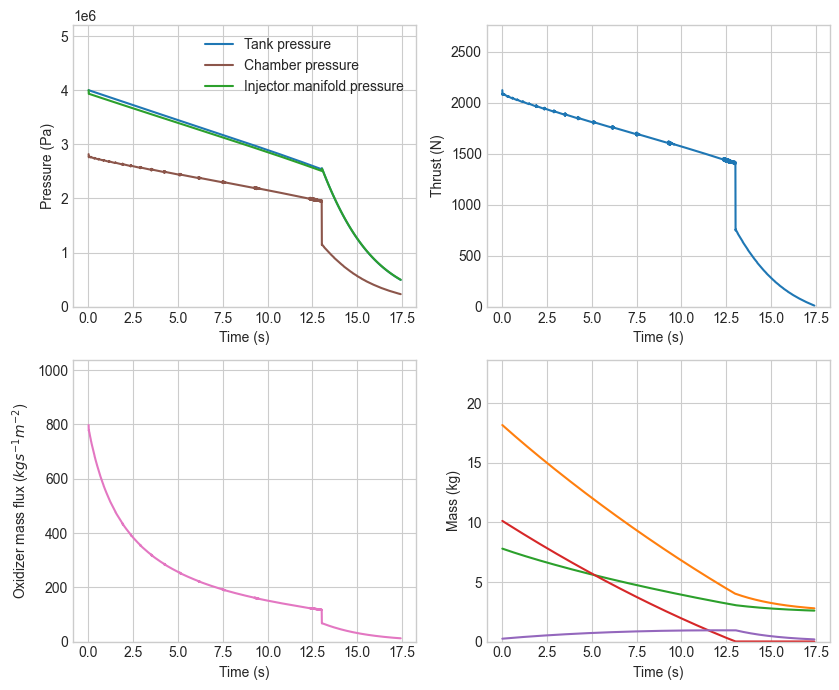

In [24]:
###############################################################################
# Plot results
###############################################################################

#plot pressures
plt.figure(figsize=(8.5, 7))
plt.subplot(221)
plt.plot(time_data, vap_pres_data, 'C0', label='Tank pressure')
plt.plot(time_data, pres_cham_data, 'C5', label='Chamber pressure')
plt.plot(time_data, manifold_pres_data, 'C2', label='Injector manifold pressure')
plt.ylabel('Pressure (Pa)')
plt.ylim(0, max(manifold_pres_data)*1.3)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.tight_layout()

#plot thrust
plt.subplot(222)
plt.plot(time_data, thrust_data)
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.ylim(0, max(thrust_data)*1.3)
plt.tight_layout()

#plot massflux
plt.subplot(223)
plt.plot(time_data, gox_data, 'C6')
plt.xlabel('Time (s)')
plt.ylabel('Oxidizer mass flux ($kg s^{-1} m^{-2}$)')
plt.ylim(0, max(gox_data)*1.3)
plt.tight_layout()

#plot masses
plt.subplot(224)
plt.plot(time_data, prop_mass_data, 'C1', label='Tank pressure')
plt.plot(time_data, fuel_mass_data, 'C2', label='Tank pressure')
plt.plot(time_data, lmass_data, 'C3', label='Tank pressure')
plt.plot(time_data, vmass_data, 'C4', label='Tank pressure')
plt.xlabel('Time (s)')
plt.ylabel('Mass (kg)')
plt.ylim(0, max(prop_mass_data)*1.3)
plt.tight_layout()
plt.savefig("log/plot_test.png")
plt.show()


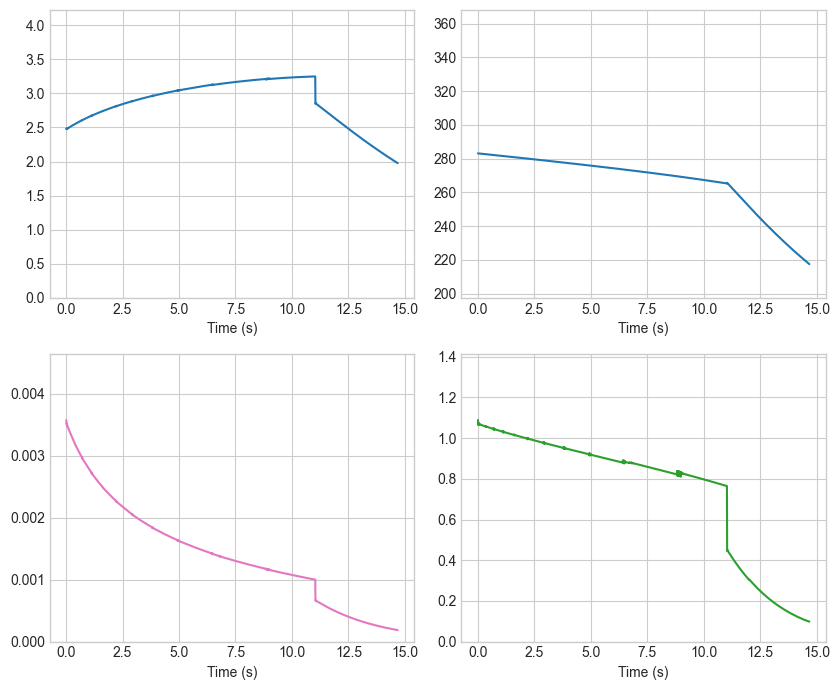

In [32]:

#Quick graphs for other, less important data
fooo1=of_data
fooo2=temp_data
fooo3=rdot_data
fooo4=pres_exit_data

plt.figure(figsize=(8.5, 7))
plt.subplot(221)
plt.plot(time_data, fooo1, 'C0')
plt.ylim(0, max(fooo1)*1.3)
plt.xlabel('Time (s)')
plt.legend()
plt.tight_layout()

plt.subplot(222)
plt.plot(time_data, fooo2)
plt.xlabel('Time (s)')
plt.ylim(min(fooo2)-20, max(fooo2)*1.3)
plt.tight_layout()

plt.subplot(223)
plt.plot(time_data, fooo3, 'C6')
plt.xlabel('Time (s)')
plt.ylim(0, max(fooo3)*1.3)
plt.tight_layout()

plt.subplot(224)
plt.plot(time_data, fooo4, 'C2') #green
plt.xlabel('Time (s)')
plt.ylim(0, max(fooo4)*1.3)
plt.tight_layout()


In [ ]:
error_command_to_keep_eng_file_from_creating_without_manual_interaction_when_restart_button_is_pressed

In [ ]:
###############################################################################
# generate a .eng motor file for RAS Aero or OpenRocket
###############################################################################
"""
Total impulse: 13784.066766981394
Initial thrust: 3020.5147027265652
"""
RASP_DIA = 120      # motor diameter in mm
RASP_LENGTH = 1842  # motor length in mm
RASP_DRY = 1.633       # motor dry mass in kg
RASP_NAME = "0deg_with_he" #name 
RASP_PROP_MASS = prop_mass_data[0]+M_HE
RASP_MANUFACTURER = "PWr in Space" #motor author, also if you are reading this, check out pwrinspace.pwr.edu.pl to see people our team!

with open(RASP_NAME+"_hybrid.eng", "w+") as rasp_file:

    rasp_file.write(f'; {VOL_TANK} {M_HE} \n')
    rasp_file.write(f'{RASP_NAME} {RASP_DIA} {RASP_LENGTH} P'
                    f' {RASP_PROP_MASS:.2f}'
                    f' {RASP_PROP_MASS + RASP_DRY:.2f} {RASP_MANUFACTURER}\n')

    for i in range(60): #spilt thrust curve into 60 data points
        t = int(i * len(time_data) / 60)
        rasp_file.write(
                f'\t{float(time_data[t]):.2f} {float(thrust_data[t]):.2f}\n')

    rasp_file.write(f'\t{float(time_data[-1]):.2f} 0.0\n')
    rasp_file.write(';')